In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import time
import imp
import os
import os, os.path
import datetime as dt
import dateutil.parser as dp
import dill
import datetime as dt

%matplotlib inline

In [36]:
# TODO: now it loads just from dill, but need to add a feature to build dataset from csv files in repo
if False:
    #df = pd.read_csv('./data/pools_ge2500_loans.csv')

    # load dataset of pools with >=250 loans
    df = pd.DataFrame()
    for root, dirs, files in os.walk("./data"):
        for name in files:
            file_name = os.path.join(root, name)
            if 'pools_ge250_loans' in file_name:
                if len(df) > 0:
                    df = pd.concat([df,pd.read_csv(file_name)])
                else:
                    df = pd.read_csv(file_name)        
                print(file_name)   
else:
    dill.load_session('notebook_env_all_3_dfs.db')

    print('attr_df.shape = ', attr_df.shape)
    print('geo_df.shape = ', geo_df.shape)
    print('seller_df.shape = ', seller_df.shape)

    df = attr_df.merge(geo_df,on=['cusip','asofdate'])
    df = df.drop('Label_y',axis=1)
    df = df.drop(['poolno_y','poolno_x','Label_x'],axis=1)
    seller_df = seller_df.drop('Label',axis=1)
    df = df.merge(seller_df,on=['cusip','asofdate'])
    df = df.drop(['Prefix_y','Prefix_x'],axis=1)

    df['Seasonality'] = df['asofdate'].apply(lambda x: int(str(x)[-2:]))

    df['asofdate'] = df['asofdate'].apply(lambda x: dt.date(int(str(x)[:4]),int(str(x)[-2:]),1))

print('df.shape = ', df.shape)

attr_df.shape =  (10143061, 59)
geo_df.shape =  (9929896, 58)
seller_df.shape =  (9636863, 27)
df.shape =  (9219204, 134)


In [37]:
# # Write df into a sequence of small files
# nloans = 250
# ddf = df[df['cnloans']>=nloans]

# print(f'ddf.shape = {ddf.shape}')

# rows = ddf.shape[0]

# N = rows//30000 + 1

# for i in range(N):
#     ddf.iloc[i*30000:(i+1)*30000,].to_csv(f'data/pools_ge{nloans}_loans_part{i+1}.csv',index=False)

In [38]:
# define columns to be used in the model and define which subset of all data will be used in model fitting 
# for example, keeping only the pools with a significant amount of loans reduces statistical noise in the data and makes model fitting easier
model_columns = ['SMM',
                 'ONLoans','cnloans',
                 'spread',
                 'DayCount','Seasonality','factor',
                 'Wac','Wam','Age',
                 'aols','waols',
                 'CSato',
                 'fico',
                 'cltv','ccltv',
                 'dti',
                 'PurpPct_purchase','PurpPct_refi',
                 'PctChannel_Broker','PctChannel_Corr','PctChannel_Retail',
                 'OccPct_investor','OccPct_owner','PropUnitsPct_2-4',
                
                 # features showing geographical composition of a pool
                 'StatePct_AK','StatePct_AL','StatePct_AR','StatePct_AZ','StatePct_CA','StatePct_CO','StatePct_CT',
                 'StatePct_DC','StatePct_DE','StatePct_FL','StatePct_GA','StatePct_GU','StatePct_HI','StatePct_IA',
                 'StatePct_ID','StatePct_IL','StatePct_IN','StatePct_KS','StatePct_KY','StatePct_LA','StatePct_MA',
                 'StatePct_MD','StatePct_ME','StatePct_MI','StatePct_MN','StatePct_MO','StatePct_MS','StatePct_MT',
                 'StatePct_NC','StatePct_ND','StatePct_NE','StatePct_NH','StatePct_NJ','StatePct_NM','StatePct_NV',
                 'StatePct_NY','StatePct_OH','StatePct_OK','StatePct_OR','StatePct_PA','StatePct_PR','StatePct_RI',
                 'StatePct_SC','StatePct_SD','StatePct_TN','StatePct_TX','StatePct_UT','StatePct_VA','StatePct_VI',
                 'StatePct_VT','StatePct_WA','StatePct_WI','StatePct_WV','StatePct_WY',
                 
                 # features showing originator composition of a pool
                 'SellerPct_AMRHT','SellerPct_ALS','SellerPct_CAFULL','SellerPct_CNTL','SellerPct_CITIZ',
                 'SellerPct_53','SellerPct_FIR','SellerPct_FRDOM','SellerPct_GUILD','SellerPct_CHASE',
                 'SellerPct_LLSL','SellerPct_MATRX','SellerPct_NCM','SellerPct_NATIONST','SellerPct_NRESM',
                 'SellerPct_PNYMAC','SellerPct_PILOSI','SellerPct_QUICK','SellerPct_REG','SellerPct_RMSC',
                 'SellerPct_UNSHFI','SellerPct_WFHM']

dfm = df[model_columns]

dfm = dfm[dfm['cnloans']>=2500]

#dfm = dfm[dfm['oltv']<=80]

len(dfm)

14679

In [39]:
# prepare data for feeding into the model - drop columns we don't need and create dummie variables for categorical features

# TODO: need to fill in missing features instead of dropping all NAs
dfm.dropna(inplace=True)

dfm = dfm.drop(['ONLoans','cnloans'],axis=1)

dummies = pd.get_dummies(dfm['Seasonality'],drop_first=True)
dfm = dfm.drop('Seasonality',axis=1)
dfm = pd.concat([dfm,dummies],axis=1)

dfm.head()

,SMM,spread,DayCount,factor,Wac,Wam,Age,aols,waols,CSato,...,3,4,5,6,7,8,9,10,11,12
3411566,1.8114,50.6,22.0,79.393105,4.011,344.0,13.0,304369.0,304369.0,10.0,...,0,0,1,0,0,0,0,0,0,0
3411567,1.8982,51.9,20.0,77.765071,4.010,342.0,14.0,303652.0,303652.0,10.0,...,0,0,0,1,0,0,0,0,0,0
3411568,1.0998,20.7,22.0,76.789096,4.010,341.0,15.0,303034.0,303034.0,10.0,...,0,0,0,0,1,0,0,0,0,0
3411569,0.7080,-21.1,22.0,76.125236,4.009,340.0,16.0,302748.0,302748.0,10.0,...,0,0,0,0,0,1,0,0,0,0
3411570,0.6786,-40.4,20.0,75.488851,4.009,339.0,17.0,302688.0,302688.0,10.0,...,0,0,0,0,0,0,1,0,0,0


In [40]:
# define train/test split
# TODO: need to add an option to define train/test split in/out of sample by factor date

from sklearn.model_selection import train_test_split

X = dfm.drop('SMM',axis=1)
y = dfm['SMM']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

X_train.shape

(3453, 108)

In [41]:
# scale train/test data because buiding a neural net
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [42]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Dropout

In [43]:
model = Sequential()

#input layer / first hidden layer
model.add(Dense(512, input_dim=X_train.shape[1], activation='relu'))
#model.add(Dropout(0.3))
model.add(Dropout(0.5))

# hidden layers
model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.3))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.3))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
# model.add(Dropout(0.5))

#output layer
model.add(Dense(1)) # no activation means linear activation a(x)=x

model.compile(optimizer='adam', loss='mse')
#model.compile(optimizer='rmsprop', loss='mse')

In [44]:
model.fit(x=X_train,
          y=y_train.values,
          validation_data=(X_test,y_test.values),
          batch_size=1024,
          epochs=130)

Train on 3453 samples, validate on 1481 samples
Epoch 1/130
3453/3453 [==============================] - 0s 104us/sample - loss: 2.1107 - val_loss: 0.9909
Epoch 2/130
3453/3453 [==============================] - 0s 22us/sample - loss: 1.3138 - val_loss: 1.0028
Epoch 3/130
3453/3453 [==============================] - 0s 20us/sample - loss: 1.1605 - val_loss: 1.2531
Epoch 4/130
3453/3453 [==============================] - 0s 20us/sample - loss: 1.0776 - val_loss: 0.9895
Epoch 5/130
3453/3453 [==============================] - 0s 20us/sample - loss: 0.9692 - val_loss: 0.8362
Epoch 6/130
3453/3453 [==============================] - 0s 20us/sample - loss: 0.9190 - val_loss: 1.0005
Epoch 7/130
3453/3453 [==============================] - 0s 20us/sample - loss: 0.8868 - val_loss: 0.8251
Epoch 8/130
3453/3453 [==============================] - 0s 19us/sample - loss: 0.7857 - val_loss: 0.7002
Epoch 9/130
3453/3453 [==============================] - 0s 20us/sample - loss: 0.7636 - val_loss: 0.77

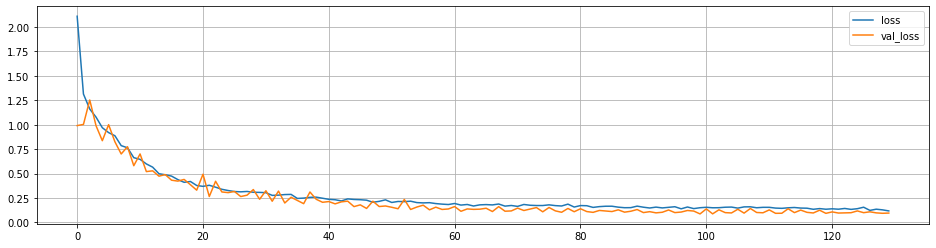

In [45]:
losses = pd.DataFrame(model.history.history)

losses.plot(figsize=(16,4),grid=True)

In [46]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score

In [47]:
test_predictions = model.predict(X_test)

In [48]:
mean_absolute_error(y_test,test_predictions)

0.21210957897982832

In [49]:
np.sqrt(mean_squared_error(y_test,test_predictions))

0.3081982152380557

In [50]:
explained_variance_score(y_test,test_predictions)

0.9106889337235774

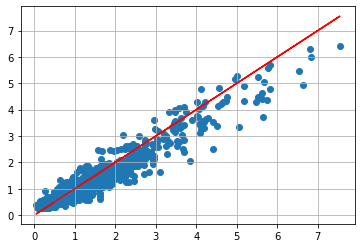

In [51]:
plt.scatter(y_test,test_predictions)

plt.plot(y_test,y_test,'r'); plt.grid()

In [52]:
train_predictions = model.predict(X_train)

In [53]:
mean_absolute_error(y_train,train_predictions)

0.17869617105189042

In [54]:
np.sqrt(mean_squared_error(y_train,train_predictions))

0.2521929123670704

In [55]:
explained_variance_score(y_train,train_predictions)

0.9430399145477459

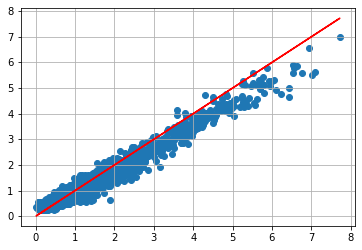

In [56]:
plt.scatter(y_train,train_predictions)

plt.plot(y_train,y_train,'r'); plt.grid()

In [57]:
dfm_with_predictions = dfm
dfm_with_predictions.head()

,SMM,spread,DayCount,factor,Wac,Wam,Age,aols,waols,CSato,...,3,4,5,6,7,8,9,10,11,12
3411566,1.8114,50.6,22.0,79.393105,4.011,344.0,13.0,304369.0,304369.0,10.0,...,0,0,1,0,0,0,0,0,0,0
3411567,1.8982,51.9,20.0,77.765071,4.010,342.0,14.0,303652.0,303652.0,10.0,...,0,0,0,1,0,0,0,0,0,0
3411568,1.0998,20.7,22.0,76.789096,4.010,341.0,15.0,303034.0,303034.0,10.0,...,0,0,0,0,1,0,0,0,0,0
3411569,0.7080,-21.1,22.0,76.125236,4.009,340.0,16.0,302748.0,302748.0,10.0,...,0,0,0,0,0,1,0,0,0,0
3411570,0.6786,-40.4,20.0,75.488851,4.009,339.0,17.0,302688.0,302688.0,10.0,...,0,0,0,0,0,0,1,0,0,0


In [58]:
dfm_with_predictions['model SMM'] = model.predict(scaler.transform(dfm_with_predictions.drop('SMM',axis=1)))

In [59]:
dfm_with_predictions = dfm_with_predictions.join(df[['asofdate','cusip','CBal','Coupon']])

In [60]:
dfm_with_predictions.head()

,SMM,spread,DayCount,factor,Wac,Wam,Age,aols,waols,CSato,...,8,9,10,11,12,model SMM,asofdate,cusip,CBal,Coupon
3411566,1.8114,50.6,22.0,79.393105,4.011,344.0,13.0,304369.0,304369.0,10.0,...,0,0,0,0,0,1.543564,2013-05-01,3138LURR8,1.42912e+09,3.5
3411567,1.8982,51.9,20.0,77.765071,4.010,342.0,14.0,303652.0,303652.0,10.0,...,0,0,0,0,0,1.642294,2013-06-01,3138LURR8,1.39982e+09,3.5
3411568,1.0998,20.7,22.0,76.789096,4.010,341.0,15.0,303034.0,303034.0,10.0,...,0,0,0,0,0,1.104224,2013-07-01,3138LURR8,1.38225e+09,3.5
3411569,0.7080,-21.1,22.0,76.125236,4.009,340.0,16.0,302748.0,302748.0,10.0,...,1,0,0,0,0,0.670918,2013-08-01,3138LURR8,1.3703e+09,3.5
3411570,0.6786,-40.4,20.0,75.488851,4.009,339.0,17.0,302688.0,302688.0,10.0,...,0,1,0,0,0,0.549001,2013-09-01,3138LURR8,1.35884e+09,3.5


In [61]:
dfm_with_predictions['CBal'] = dfm_with_predictions['CBal'].apply(lambda x: float(x))

In [62]:
dfm_with_predictions['SMM x CBal'] = dfm_with_predictions.apply(lambda x: x['SMM']*x['CBal'],axis=1)
dfm_with_predictions['model SMM x CBal'] = dfm_with_predictions.apply(lambda x: x['model SMM']*x['CBal'],axis=1)

In [63]:
dfm_with_predictions.head()

,SMM,spread,DayCount,factor,Wac,Wam,Age,aols,waols,CSato,...,10,11,12,model SMM,asofdate,cusip,CBal,Coupon,SMM x CBal,model SMM x CBal
3411566,1.8114,50.6,22.0,79.393105,4.011,344.0,13.0,304369.0,304369.0,10.0,...,0,0,0,1.543564,2013-05-01,3138LURR8,1.429123e+09,3.5,2.588713e+09,2.205942e+09
3411567,1.8982,51.9,20.0,77.765071,4.010,342.0,14.0,303652.0,303652.0,10.0,...,0,0,0,1.642294,2013-06-01,3138LURR8,1.399817e+09,3.5,2.657133e+09,2.298911e+09
3411568,1.0998,20.7,22.0,76.789096,4.010,341.0,15.0,303034.0,303034.0,10.0,...,0,0,0,1.104224,2013-07-01,3138LURR8,1.382249e+09,3.5,1.520197e+09,1.526312e+09
3411569,0.7080,-21.1,22.0,76.125236,4.009,340.0,16.0,302748.0,302748.0,10.0,...,0,0,0,0.670918,2013-08-01,3138LURR8,1.370299e+09,3.5,9.701717e+08,9.193584e+08
3411570,0.6786,-40.4,20.0,75.488851,4.009,339.0,17.0,302688.0,302688.0,10.0,...,0,0,0,0.549001,2013-09-01,3138LURR8,1.358844e+09,3.5,9.221114e+08,7.460063e+08


In [64]:
temp = dfm_with_predictions[['Coupon','asofdate','SMM x CBal','model SMM x CBal','CBal']]

In [65]:
temp = temp.groupby(['Coupon','asofdate']).sum()

temp['total SMM'] = temp['SMM x CBal']/temp['CBal']
temp['total model SMM'] = temp['model SMM x CBal']/temp['CBal']

temp['CPR'] = 100*(1-(1-temp['total SMM']/100)**12)
temp['model CPR'] = 100*(1-(1-temp['total model SMM']/100)**12)

In [66]:
temp.head()

SMM x CBal  model SMM x CBal          CBal  total SMM  \
Coupon asofdate                                                              
2.5    2019-08-01  1.652471e+08      9.188824e+08  2.929913e+09   0.056400   
       2019-09-01  1.594912e+09      2.800234e+09  8.436138e+09   0.189057   
       2019-10-01  2.870268e+09      6.647764e+09  1.779513e+10   0.161295   
       2019-11-01  4.136498e+09      8.622491e+09  2.487676e+10   0.166280   
       2019-12-01  5.570368e+09      1.271339e+10  3.338525e+10   0.166851   

                   total model SMM       CPR  model CPR  
Coupon asofdate                                          
2.5    2019-08-01         0.313621  0.674705   3.699210  
       2019-09-01         0.331933  2.245243   3.911277  
       2019-10-01         0.373572  1.918463   4.391895  
       2019-11-01         0.346608  1.977208   4.080919  
       2019-12-01         0.380809  1.983942   4.475199

In [67]:
for i, row in temp.iterrows():    
    print(f"Prepay month = {i} | CPR = {np.round(row['CPR'],1)} | Model CPR = {np.round(row['model CPR'],1)}")

Prepay month = (2.5, datetime.date(2019, 8, 1)) | CPR = 0.7 | Model CPR = 3.7
Prepay month = (2.5, datetime.date(2019, 9, 1)) | CPR = 2.2 | Model CPR = 3.9
Prepay month = (2.5, datetime.date(2019, 10, 1)) | CPR = 1.9 | Model CPR = 4.4
Prepay month = (2.5, datetime.date(2019, 11, 1)) | CPR = 2.0 | Model CPR = 4.1
Prepay month = (2.5, datetime.date(2019, 12, 1)) | CPR = 2.0 | Model CPR = 4.5
Prepay month = (3.0, datetime.date(2013, 5, 1)) | CPR = 5.0 | Model CPR = 5.8
Prepay month = (3.0, datetime.date(2013, 6, 1)) | CPR = 4.0 | Model CPR = 5.5
Prepay month = (3.0, datetime.date(2013, 7, 1)) | CPR = 3.6 | Model CPR = 4.5
Prepay month = (3.0, datetime.date(2013, 8, 1)) | CPR = 3.1 | Model CPR = 3.8
Prepay month = (3.0, datetime.date(2013, 9, 1)) | CPR = 2.8 | Model CPR = 3.6
Prepay month = (3.0, datetime.date(2013, 10, 1)) | CPR = 2.9 | Model CPR = 3.7
Prepay month = (3.0, datetime.date(2013, 11, 1)) | CPR = 2.6 | Model CPR = 3.8
Prepay month = (3.0, datetime.date(2013, 12, 1)) | CPR = 4.

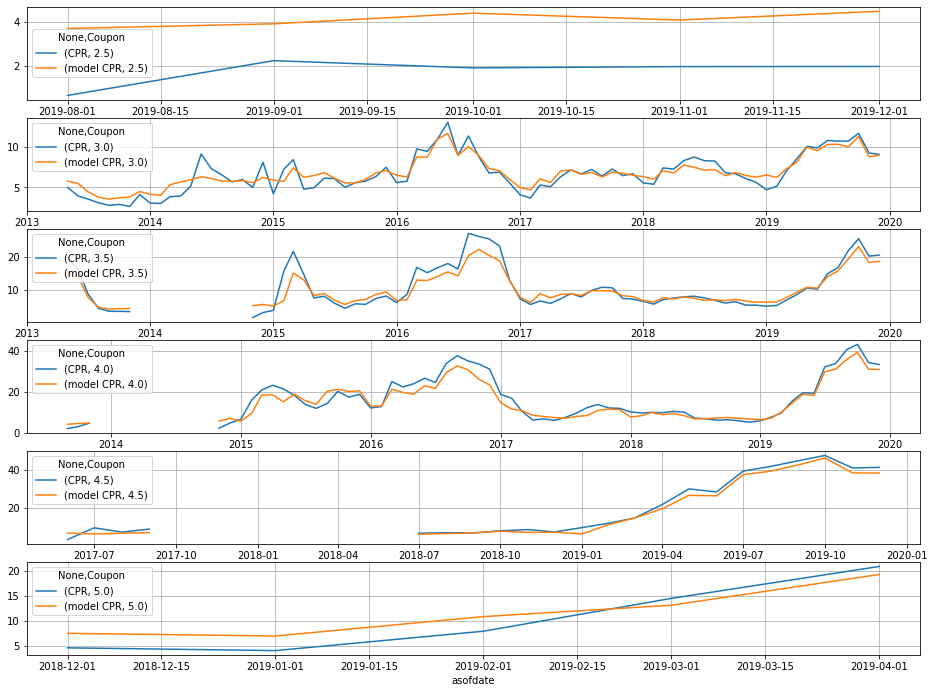

In [68]:
fig = plt.figure(figsize=(16,16))

for i in range(6):
    ax = fig.add_subplot(8,1,i+1)
    coupon = 2.5+i*0.5
    temp[['CPR','model CPR']].unstack(level=0)[[('CPR',coupon),('model CPR',coupon)]].plot(ax=ax,grid=True)